In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split


wave_len=100


def create_model():

    input_layer = layers.Input(shape=(1024, wave_len))# 输入层，形状为 (1024, 10)
    x = tf.expand_dims(input_layer, axis=-1)# 增加一个维度，形状变为 (1024, 10, 1)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第一层Conv2D，输出形状为 (1024, 10, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (512, 10, 10)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第二层Conv2D，输出形状为 (512, 10, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (256, 10, 10)
    x = layers.Conv2D(filters=1, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第三层Conv2D，输出形状为 (256, 10, 1)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (128, 10, 1)
    x = tf.squeeze(x, axis=-1)# 去除最后的维度，输出形状为 (128, 10)
    assert x.shape[1:] == (128, wave_len), f"Expected shape (128, 60), but got {x.shape[1:]}"# 验证形状
    conv1d_layer = x
    # Self-attention layers
    attention_layer1 = MultiHeadAttention(num_heads=10, key_dim=100)(conv1d_layer, conv1d_layer)# 第一层自注意力，输出形状为 (128, 10)
    attention_layer2 = MultiHeadAttention(num_heads=10, key_dim=100)(attention_layer1, attention_layer1)# 第二层自注意力，输出形状为 (128, 10)

    # Flatten layer
    flatten_layer = Flatten()(attention_layer2)

    output_layer = Dense(1, activation='sigmoid')(flatten_layer)# 二分类全连接层，输出形状为 (1,)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer)# 创建模型

    return model

# 使用函数


jian_data = np.load('/content/drive/My Drive/Colab Notebooks/jian_100data.npy')
la_data = np.load('/content/drive/My Drive/Colab Notebooks/la_100data.npy')


quarter_size_jian = int(jian_data.shape[0])
quarter_size_la = int(la_data.shape[0])
jian_data = jian_data[:quarter_size_jian]
la_data = la_data[:quarter_size_la]
print(jian_data.shape,la_data.shape)

jian_labels = np.ones((jian_data.shape[0], 1))# "jian"类别数据的标签为1
la_labels = np.zeros((la_data.shape[0], 1))# "la"类别数据的标签为0

# Concatenate the data and labels
data = np.concatenate([jian_data, la_data])
labels = np.concatenate([jian_labels, la_labels])# 将两类数据和标签拼接起来，得到完整的数据集

# Split the data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)# 将完整的数据集分割为训练集和验证集,这里我们保留20%的数据作为验证集

# Create the model
model = create_model()# 创建模型

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])# 使用adam优化器，损失函数为二元交叉熵，评价指标为准确率

# Train the model
model.fit(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels))# 使用训练数据进行训练，同时使用验证数据进行验证，训练10个周期


(5196, 1024, 100) (5966, 1024, 100)
Epoch 1/10
280/280 [==============================] - 10s 22ms/step - loss: 0.0660 - accuracy: 0.9777 - val_loss: 0.0151 - val_accuracy: 0.9951
Epoch 2/10
280/280 [==============================] - 5s 17ms/step - loss: 0.0152 - accuracy: 0.9963 - val_loss: 0.0171 - val_accuracy: 0.9987
Epoch 3/10
280/280 [==============================] - 5s 17ms/step - loss: 0.0138 - accuracy: 0.9960 - val_loss: 0.0112 - val_accuracy: 0.9987
Epoch 4/10
280/280 [==============================] - 5s 16ms/step - loss: 0.0151 - accuracy: 0.9972 - val_loss: 0.0223 - val_accuracy: 0.9987
Epoch 5/10
280/280 [==============================] - 5s 16ms/step - loss: 0.0131 - accuracy: 0.9971 - val_loss: 0.6892 - val_accuracy: 0.7882
Epoch 6/10
280/280 [==============================] - 5s 16ms/step - loss: 4.9553 - accuracy: 0.9623 - val_loss: 0.5065 - val_accuracy: 0.9942
Epoch 7/10
280/280 [==============================] - 5s 17ms/step - loss: 0.1107 - accuracy: 0.9968 - va

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as pl
sentence_length = 100


def preprocess_and_concatenate(directory, step_size ):
    # 获取指定目录下的所有文件
    files = os.listdir(directory)
    # 过滤出所有的 .npy 文件
    npy_files = [f for f in files if f.endswith('.npy')]

    # 初始化一个空列表来存储数据
    all_data = []

    # 遍历每一个 .npy 文件
    for npy_file in npy_files:

        data = np.load(os.path.join(directory, npy_file))
        num_to_delete = data.shape[0] % step_size
        if num_to_delete != 0:
            data = np.delete(data, np.s_[-num_to_delete:], axis=0)


        len_data = data.shape[0]
        sentences = []
        for i in range(0, len_data - sentence_length + 1, step_size):
            sentence = data[i:i + sentence_length].T
            sentences.append(sentence)

        reshape_data = np.stack(sentences, axis=0)


        all_data.append(reshape_data)

    # 将所有的数据拼接到一起
    all_data = np.concatenate(all_data, axis=0)


    return all_data

# 调用函数

def create_model():

    input_layer = layers.Input(shape=(1024, sentence_length))# 输入层，形状为 (1024, 10)
    x = tf.expand_dims(input_layer, axis=-1)# 增加一个维度，形状变为 (1024, 10, 1)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第一层Conv2D，输出形状为 (1024, 10, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (512, 10, 10)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第二层Conv2D，输出形状为 (512, 10, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (256, 10, 10)
    x = layers.Conv2D(filters=1, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第三层Conv2D，输出形状为 (256, 10, 1)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (128, 10, 1)
    x = tf.squeeze(x, axis=-1)# 去除最后的维度，输出形状为 (128, 10)
    assert x.shape[1:] == (128, sentence_length), f"Expected shape (128, 60), but got {x.shape[1:]}"# 验证形状
    conv1d_layer = x
    # Self-attention layers
    attention_layer1 = MultiHeadAttention(num_heads=10, key_dim=100)(conv1d_layer, conv1d_layer)# 第一层自注意力，输出形状为 (128, 10)
    attention_layer2 = MultiHeadAttention(num_heads=10, key_dim=100)(attention_layer1, attention_layer1)# 第二层自注意力，输出形状为 (128, 10)

    # Flatten layer
    flatten_layer = Flatten()(attention_layer2)

    output_layer = Dense(1, activation='sigmoid')(flatten_layer)# 二分类全连接层，输出形状为 (1,)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer)# 创建模型

    return model

la_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/la',60)
jian_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/jian',20)


print(f"Jian 数据形状: {jian_data.shape}, La 数据形状: {la_data.shape}")
jian_labels = np.ones((jian_data.shape[0], 1))# "jian"类别数据的标签为1
la_labels = np.zeros((la_data.shape[0], 1))# "la"类别数据的标签为0

data = np.concatenate([jian_data, la_data])
labels = np.concatenate([jian_labels, la_labels])# 将两类数据和标签拼接起来，得到完整的数据集


train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=1022)# 将完整的数据集分割为训练集和验证集,这里我们保留20%的数据作为验证集

model = create_model()# 创建模型

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])# 使用adam优化器，损失函数为二元交叉熵，评价指标为准确率
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
start_time = time.time()
history = model.fit(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels),
                    callbacks=[early_stopping, model_checkpoint])
end_time = time.time()
elapsed_time = end_time - start_time
print(f"经过的时间: {elapsed_time} 秒")
history_df = pd.DataFrame(history.history)

# 保存为 CSV 文件
history_df.to_csv("training_history.csv", index=False)
#72.85914921760559 秒


Jian 数据形状: (6791, 1024, 100), La 数据形状: (7287, 1024, 100)
Epoch 1/50
352/352 [==============================] - 27s 32ms/step - loss: 0.0753 - accuracy: 0.9712 - val_loss: 0.0155 - val_accuracy: 0.9986
Epoch 2/50
352/352 [==============================] - 8s 23ms/step - loss: 0.0189 - accuracy: 0.9955 - val_loss: 0.0120 - val_accuracy: 0.9972
Epoch 3/50
352/352 [==============================] - 8s 23ms/step - loss: 0.0196 - accuracy: 0.9963 - val_loss: 0.0123 - val_accuracy: 0.9986
Epoch 4/50
352/352 [==============================] - 8s 23ms/step - loss: 0.0159 - accuracy: 0.9967 - val_loss: 0.0134 - val_accuracy: 0.9972
Epoch 5/50
352/352 [==============================] - 8s 23ms/step - loss: 0.0117 - accuracy: 0.9982 - val_loss: 0.0238 - val_accuracy: 0.9929
经过的时间: 72.85914921760559 秒


Jian 数据形状: (6791, 1024, 100), La 数据形状: (7287, 1024, 100)
88/88 [==============================] - 1s 10ms/step
经过的时间: 3.790616035461426 秒
准确率: 0.9971590909090909
召回率: 0.9970304380103935
精确度: 0.9970304380103935
F1得分: 0.9970304380103935
ROC-AUC: 0.9971537486171776
混淆矩阵: 
[[1465    4]
 [   4 1343]]


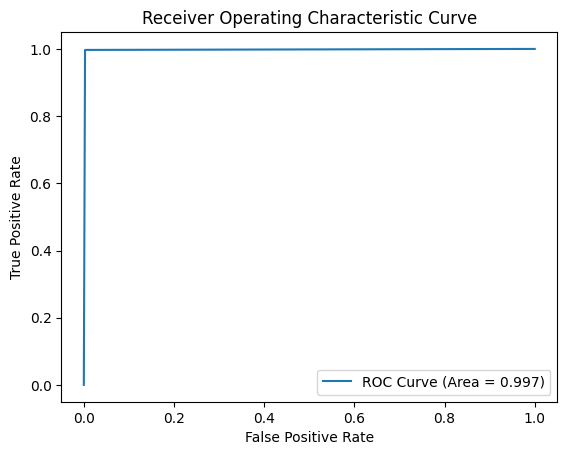

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
sentence_length = 100


def preprocess_and_concatenate(directory, step_size ):
    # 获取指定目录下的所有文件
    files = os.listdir(directory)
    # 过滤出所有的 .npy 文件
    npy_files = [f for f in files if f.endswith('.npy')]

    # 初始化一个空列表来存储数据
    all_data = []

    # 遍历每一个 .npy 文件
    for npy_file in npy_files:

        data = np.load(os.path.join(directory, npy_file))
        num_to_delete = data.shape[0] % step_size
        if num_to_delete != 0:
            data = np.delete(data, np.s_[-num_to_delete:], axis=0)


        len_data = data.shape[0]
        sentences = []
        for i in range(0, len_data - sentence_length + 1, step_size):
            sentence = data[i:i + sentence_length].T
            sentences.append(sentence)

        reshape_data = np.stack(sentences, axis=0)


        all_data.append(reshape_data)

    # 将所有的数据拼接到一起
    all_data = np.concatenate(all_data, axis=0)


    return all_data

# 调用函数

def create_model():

    input_layer = layers.Input(shape=(1024, sentence_length))# 输入层，形状为 (1024, 100)
    x = tf.expand_dims(input_layer, axis=-1)# 增加一个维度，形状变为 (1024, 100, 1)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第一层Conv2D，输出形状为 (1024, 100, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (512, 100, 10)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第二层Conv2D，输出形状为 (512, 100, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (256, 100, 10)
    x = layers.Conv2D(filters=1, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第三层Conv2D，输出形状为 (256, 100, 1)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (128, 100, 1)
    x = tf.squeeze(x, axis=-1)# 去除最后的维度，输出形状为 (128, 100)

    conv1d_layer = x
    # Self-attention layers
    attention_layer1 = MultiHeadAttention(num_heads=10, key_dim=100)(conv1d_layer, conv1d_layer)# 第一层自注意力，输出形状为 (128, 10)
    attention_layer2 = MultiHeadAttention(num_heads=10, key_dim=100)(attention_layer1, attention_layer1)# 第二层自注意力，输出形状为 (128, 10)

    # Flatten layer
    flatten_layer = Flatten()(attention_layer2)

    output_layer = Dense(1, activation='sigmoid')(flatten_layer)# 二分类全连接层，输出形状为 (1,)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer)# 创建模型

    return model

la_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/la',60)
jian_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/jian',20)


print(f"Jian 数据形状: {jian_data.shape}, La 数据形状: {la_data.shape}")
jian_labels = np.ones((jian_data.shape[0], 1))# "jian"类别数据的标签为1
la_labels = np.zeros((la_data.shape[0], 1))# "la"类别数据的标签为0

data = np.concatenate([jian_data, la_data])
labels = np.concatenate([jian_labels, la_labels])# 将两类数据和标签拼接起来，得到完整的数据集


train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=1022)# 将完整的数据集分割为训练集和验证集,这里我们保留20%的数据作为验证集
best_model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/best_model.h5")
start_time = time.time()
val_preds = best_model.predict(val_data)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"经过的时间: {elapsed_time} 秒")
val_preds = np.round(val_preds)
tn, fp, fn, tp = confusion_matrix(val_labels, val_preds).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
recall = recall_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)
roc_auc = roc_auc_score(val_labels, val_preds)

# 打印并保存指标
print(f"准确率: {accuracy}")
print(f"召回率: {recall}")
print(f"精确度: {precision}")
print(f"F1得分: {f1}")
print(f"ROC-AUC: {roc_auc}")

# 保存混淆矩阵
print(f"混淆矩阵: \n{confusion_matrix(val_labels, val_preds)}")
fpr, tpr, thresholds = roc_curve(val_labels, val_preds)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (Area = {roc_auc:.3f})')  # .3f formats it to 3 decimal places
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
plt.show()



In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
sentence_length = 100


def preprocess_and_concatenate(directory, step_size ):
    # 获取指定目录下的所有文件
    files = os.listdir(directory)
    # 过滤出所有的 .npy 文件
    npy_files = [f for f in files if f.endswith('.npy')]

    # 初始化一个空列表来存储数据
    all_data = []

    # 遍历每一个 .npy 文件
    for npy_file in npy_files:

        data = np.load(os.path.join(directory, npy_file))
        num_to_delete = data.shape[0] % step_size
        if num_to_delete != 0:
            data = np.delete(data, np.s_[-num_to_delete:], axis=0)


        len_data = data.shape[0]
        sentences = []
        for i in range(0, len_data - sentence_length + 1, step_size):
            sentence = data[i:i + sentence_length].T
            sentences.append(sentence)

        reshape_data = np.stack(sentences, axis=0)


        all_data.append(reshape_data)

    # 将所有的数据拼接到一起
    all_data = np.concatenate(all_data, axis=0)


    return all_data

# 调用函数

def create_model():

    input_layer = layers.Input(shape=(1024, sentence_length))# 输入层，形状为 (1024, 100)
    x = tf.expand_dims(input_layer, axis=-1)# 增加一个维度，形状变为 (1024, 100, 1)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第一层Conv2D，输出形状为 (1024, 100, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (512, 100, 10)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第二层Conv2D，输出形状为 (512, 100, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (256, 100, 10)
    x = layers.Conv2D(filters=1, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第三层Conv2D，输出形状为 (256, 100, 1)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (128, 100, 1)
    x = tf.squeeze(x, axis=-1)# 去除最后的维度，输出形状为 (128, 100)

    conv1d_layer = x
    # Self-attention layers
    attention_layer1 = MultiHeadAttention(num_heads=10, key_dim=100)(conv1d_layer, conv1d_layer)# 第一层自注意力，输出形状为 (128, 10)
    attention_layer2 = MultiHeadAttention(num_heads=10, key_dim=100)(attention_layer1, attention_layer1)# 第二层自注意力，输出形状为 (128, 10)

    # Flatten layer
    flatten_layer = Flatten()(attention_layer2)

    output_layer = Dense(1, activation='sigmoid')(flatten_layer)# 二分类全连接层，输出形状为 (1,)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer)# 创建模型

    return model

la_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/la',60)
jian_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/jian',20)


print(f"Jian 数据形状: {jian_data.shape}, La 数据形状: {la_data.shape}")
jian_labels = np.ones((jian_data.shape[0], 1))# "jian"类别数据的标签为1
la_labels = np.zeros((la_data.shape[0], 1))# "la"类别数据的标签为0

data = np.concatenate([jian_data, la_data])
labels = np.concatenate([jian_labels, la_labels])# 将两类数据和标签拼接起来，得到完整的数据集


train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=1022)# 将完整的数据集分割为训练集和验证集,这里我们保留20%的数据作为验证集
best_model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/best_model.h5")

ntermediate_layer_model = keras.Model(inputs=best_model.input,
                                       outputs=best_model.get_layer(' max_pooling2d_2').output)

num_samples = [0,1, 2, 3,4,5,6,7,8,9,10,11,12,13,14]  # 或者任何其他你想处理的样本索引列表


for i in num_samples:
    sample_val_data = np.expand_dims(val_data[i], axis=0)
    intermediate_output = intermediate_layer_model.predict(sample_val_data)
    intermediate_output_squeezed = np.squeeze(intermediate_output, axis=-1)
    squeezed_outputs.append(intermediate_output_squeezed)

    plt.figure(figsize=(10, 10))
    plt.imshow(intermediate_output_squeezed1[0], cmap='viridis')  # 注意我们现在使用了去掉最后维度后的数据
  plt.colorbar()
plt.title("Feature map_sample1")
plt.savefig("Feature map_sample1.png")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(intermediate_output_squeezed2[0], cmap='viridis')  # 注意我们现在使用了去掉最后维度后的数据
plt.colorbar()
plt.title("Feature map_sample2")
plt.savefig("Feature map_sample1.png")
plt.show()


Jian 数据形状: (6791, 1024, 100), La 数据形状: (7287, 1024, 100)
1/1 [==============================] - 0s 16ms/step


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as pl
sentence_length = 100


def preprocess_and_concatenate(directory, step_size ):
    # 获取指定目录下的所有文件
    files = os.listdir(directory)
    # 过滤出所有的 .npy 文件
    npy_files = [f for f in files if f.endswith('.npy')]

    # 初始化一个空列表来存储数据
    all_data = []

    # 遍历每一个 .npy 文件
    for npy_file in npy_files:

        data = np.load(os.path.join(directory, npy_file))
        num_to_delete = data.shape[0] % step_size
        if num_to_delete != 0:
            data = np.delete(data, np.s_[-num_to_delete:], axis=0)


        len_data = data.shape[0]
        sentences = []
        for i in range(0, len_data - sentence_length + 1, step_size):
            sentence = data[i:i + sentence_length].T
            sentences.append(sentence)

        reshape_data = np.stack(sentences, axis=0)


        all_data.append(reshape_data)

    # 将所有的数据拼接到一起
    all_data = np.concatenate(all_data, axis=0)


    return all_data

# 调用函数

def create_model():

    input_layer = layers.Input(shape=(1024, sentence_length))# 输入层，形状为 (1024, 10)

    conv1d_layer = input_layer
    # Self-attention layers
    attention_layer1 = MultiHeadAttention(num_heads=10, key_dim=100)(conv1d_layer, conv1d_layer)# 第一层自注意力，输出形状为 (1024, 10)
    attention_layer2 = MultiHeadAttention(num_heads=10, key_dim=100)(attention_layer1, attention_layer1)# 第二层自注意力，输出形状为 (1024, 10)

    # Flatten layer
    flatten_layer = Flatten()(attention_layer2)

    output_layer = Dense(1, activation='sigmoid')(flatten_layer)# 二分类全连接层，输出形状为 (1,)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer)# 创建模型

    return model

la_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/la',60)
jian_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/jian',20)


print(f"Jian 数据形状: {jian_data.shape}, La 数据形状: {la_data.shape}")
jian_labels = np.ones((jian_data.shape[0], 1))# "jian"类别数据的标签为1
la_labels = np.zeros((la_data.shape[0], 1))# "la"类别数据的标签为0

data = np.concatenate([jian_data, la_data])
labels = np.concatenate([jian_labels, la_labels])# 将两类数据和标签拼接起来，得到完整的数据集


train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=1022)# 将完整的数据集分割为训练集和验证集,这里我们保留20%的数据作为验证集

model = create_model()# 创建模型

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])# 使用adam优化器，损失函数为二元交叉熵，评价指标为准确率
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
start_time = time.time()
history = model.fit(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels),
                    callbacks=[early_stopping, model_checkpoint])
end_time = time.time()
elapsed_time = end_time - start_time
print(f"经过的时间: {elapsed_time} 秒")
history_df = pd.DataFrame(history.history)

# 保存为 CSV 文件
history_df.to_csv("CNN_none_training_history.csv", index=False)
#72.85914921760559 秒

#14.9GBGPU


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Jian 数据形状: (6791, 1024, 100), La 数据形状: (7287, 1024, 100)
Epoch 1/50
352/352 [==============================] - 73s 182ms/step - loss: 0.7060 - accuracy: 0.5067 - val_loss: 0.7235 - val_accuracy: 0.5188
Epoch 2/50
352/352 [==============================] - 61s 175ms/step - loss: 4.4421 - accuracy: 0.5551 - val_loss: 3.0256 - val_accuracy: 0.4940
Epoch 3/50
352/352 [==============================] - 62s 175ms/step - loss: 1.8349 - accuracy: 0.6221 - val_loss: 1.3685 - val_accuracy: 0.7322
Epoch 4/50
352/352 [==============================] - 62s 175ms/step - loss: 0.8456 - accuracy: 0.6786 - val_loss: 1.4165 - val_accuracy: 0.6811
经过的时间: 271.9041814804077 秒


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Jian 数据形状: (6791, 1024, 100), La 数据形状: (7287, 1024, 100)
88/88 [==============================] - 9s 60ms/step
经过的时间: 12.236974477767944 秒
准确率: 0.5188210227272727
召回率: 0.008166295471417966
精确度: 0.36666666666666664
F1得分: 0.01597676107480029
ROC-AUC: 0.4976161633926184
混淆矩阵: 
[[1450   19]
 [1336   11]]


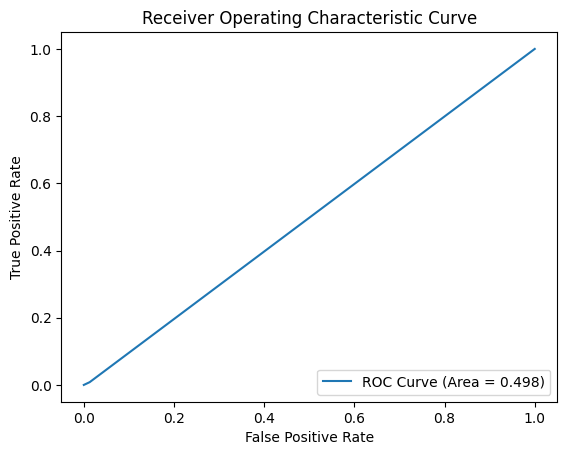

In [1]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
sentence_length = 100


def preprocess_and_concatenate(directory, step_size ):
    # 获取指定目录下的所有文件
    files = os.listdir(directory)
    # 过滤出所有的 .npy 文件
    npy_files = [f for f in files if f.endswith('.npy')]

    # 初始化一个空列表来存储数据
    all_data = []

    # 遍历每一个 .npy 文件
    for npy_file in npy_files:

        data = np.load(os.path.join(directory, npy_file))
        num_to_delete = data.shape[0] % step_size
        if num_to_delete != 0:
            data = np.delete(data, np.s_[-num_to_delete:], axis=0)


        len_data = data.shape[0]
        sentences = []
        for i in range(0, len_data - sentence_length + 1, step_size):
            sentence = data[i:i + sentence_length].T
            sentences.append(sentence)

        reshape_data = np.stack(sentences, axis=0)


        all_data.append(reshape_data)

    # 将所有的数据拼接到一起
    all_data = np.concatenate(all_data, axis=0)


    return all_data

# 调用函数



la_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/la',60)
jian_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/jian',20)


print(f"Jian 数据形状: {jian_data.shape}, La 数据形状: {la_data.shape}")
jian_labels = np.ones((jian_data.shape[0], 1))# "jian"类别数据的标签为1
la_labels = np.zeros((la_data.shape[0], 1))# "la"类别数据的标签为0

data = np.concatenate([jian_data, la_data])
labels = np.concatenate([jian_labels, la_labels])# 将两类数据和标签拼接起来，得到完整的数据集


train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=1022)# 将完整的数据集分割为训练集和验证集,这里我们保留20%的数据作为验证集
best_model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/CNN_none_best_model.h5")
start_time = time.time()
val_preds = best_model.predict(val_data)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"经过的时间: {elapsed_time} 秒")
val_preds = np.round(val_preds)
tn, fp, fn, tp = confusion_matrix(val_labels, val_preds).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
recall = recall_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)
roc_auc = roc_auc_score(val_labels, val_preds)

# 打印并保存指标
print(f"准确率: {accuracy}")
print(f"召回率: {recall}")
print(f"精确度: {precision}")
print(f"F1得分: {f1}")
print(f"ROC-AUC: {roc_auc}")

# 保存混淆矩阵
print(f"混淆矩阵: \n{confusion_matrix(val_labels, val_preds)}")
fpr, tpr, thresholds = roc_curve(val_labels, val_preds)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (Area = {roc_auc:.3f})')  # .3f formats it to 3 decimal places
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.savefig("CNN_none_roc_curve.png")
plt.show()



In [3]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as pl
sentence_length = 100


def preprocess_and_concatenate(directory, step_size ):
    # 获取指定目录下的所有文件
    files = os.listdir(directory)
    # 过滤出所有的 .npy 文件
    npy_files = [f for f in files if f.endswith('.npy')]

    # 初始化一个空列表来存储数据
    all_data = []

    # 遍历每一个 .npy 文件
    for npy_file in npy_files:

        data = np.load(os.path.join(directory, npy_file))
        num_to_delete = data.shape[0] % step_size
        if num_to_delete != 0:
            data = np.delete(data, np.s_[-num_to_delete:], axis=0)


        len_data = data.shape[0]
        sentences = []
        for i in range(0, len_data - sentence_length + 1, step_size):
            sentence = data[i:i + sentence_length].T
            sentences.append(sentence)

        reshape_data = np.stack(sentences, axis=0)


        all_data.append(reshape_data)

    # 将所有的数据拼接到一起
    all_data = np.concatenate(all_data, axis=0)


    return all_data

# 调用函数

def create_model():


    input_layer = layers.Input(shape=(1024, sentence_length))# 输入层，形状为 (1024, 10)
    x = tf.expand_dims(input_layer, axis=-1)# 增加一个维度，形状变为 (1024, 10, 1)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第一层Conv2D，输出形状为 (1024, 10, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (512, 10, 10)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第二层Conv2D，输出形状为 (512, 10, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (256, 10, 10)
    x = layers.Conv2D(filters=1, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第三层Conv2D，输出形状为 (256, 10, 1)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (128, 10, 1)
    x = tf.squeeze(x, axis=-1)# 去除最后的维度，输出形状为 (128, 10)
    conv1d_layer = x
    # Self-attention layers

    # Flatten layer
    flatten_layer = Flatten()(conv1d_layer)

    output_layer = Dense(1, activation='sigmoid')(flatten_layer)# 二分类全连接层，输出形状为 (1,)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer)# 创建模型

    return model

la_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/la',60)
jian_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/jian',20)


print(f"Jian 数据形状: {jian_data.shape}, La 数据形状: {la_data.shape}")
jian_labels = np.ones((jian_data.shape[0], 1))# "jian"类别数据的标签为1
la_labels = np.zeros((la_data.shape[0], 1))# "la"类别数据的标签为0

data = np.concatenate([jian_data, la_data])
labels = np.concatenate([jian_labels, la_labels])# 将两类数据和标签拼接起来，得到完整的数据集


train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=1022)# 将完整的数据集分割为训练集和验证集,这里我们保留20%的数据作为验证集

model = create_model()# 创建模型

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])# 使用adam优化器，损失函数为二元交叉熵，评价指标为准确率
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint("Attention_none_best_model.h5", save_best_only=True)
start_time = time.time()
history = model.fit(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels),
                    callbacks=[early_stopping, model_checkpoint])
end_time = time.time()
elapsed_time = end_time - start_time
print(f"经过的时间: {elapsed_time} 秒")
history_df = pd.DataFrame(history.history)

# 保存为 CSV 文件
history_df.to_csv("Attention_none_training_history.csv", index=False)
#34.8秒

#8.8GBGPU



Jian 数据形状: (6791, 1024, 100), La 数据形状: (7287, 1024, 100)
Epoch 1/50
352/352 [==============================] - 21s 25ms/step - loss: 0.6929 - accuracy: 0.5141 - val_loss: 0.6925 - val_accuracy: 0.5217
Epoch 2/50
352/352 [==============================] - 6s 16ms/step - loss: 0.6927 - accuracy: 0.5166 - val_loss: 0.6923 - val_accuracy: 0.5217
Epoch 3/50
352/352 [==============================] - 6s 16ms/step - loss: 0.6926 - accuracy: 0.5166 - val_loss: 0.6923 - val_accuracy: 0.5217
Epoch 4/50
352/352 [==============================] - 6s 16ms/step - loss: 0.6926 - accuracy: 0.5166 - val_loss: 0.6923 - val_accuracy: 0.5217
Epoch 5/50
352/352 [==============================] - 6s 16ms/step - loss: 0.6926 - accuracy: 0.5166 - val_loss: 0.6923 - val_accuracy: 0.5217
Epoch 6/50
352/352 [==============================] - 6s 16ms/step - loss: 0.6926 - accuracy: 0.5166 - val_loss: 0.6923 - val_accuracy: 0.5217
Epoch 7/50
352/352 [==============================] - 6s 16ms/step - loss: 0.6926 - 

Jian 数据形状: (6791, 1024, 100), La 数据形状: (7287, 1024, 100)
88/88 [==============================] - 8s 7ms/step
经过的时间: 11.431210279464722 秒
准确率: 0.5216619318181818
召回率: 0.0
精确度: 0.0
F1得分: 0.0
ROC-AUC: 0.5
混淆矩阵: 
[[1469    0]
 [1347    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


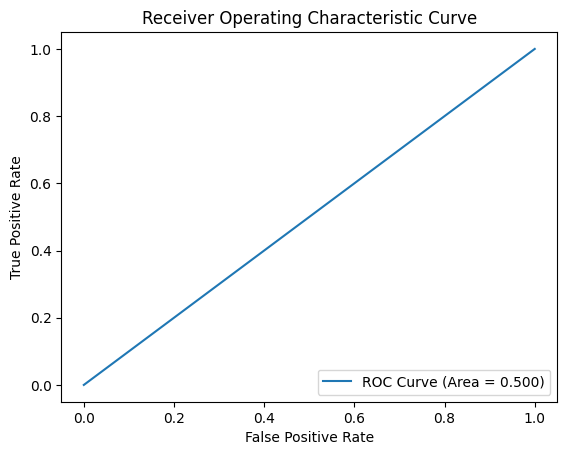

In [1]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
sentence_length = 100


def preprocess_and_concatenate(directory, step_size ):
    # 获取指定目录下的所有文件
    files = os.listdir(directory)
    # 过滤出所有的 .npy 文件
    npy_files = [f for f in files if f.endswith('.npy')]

    # 初始化一个空列表来存储数据
    all_data = []

    # 遍历每一个 .npy 文件
    for npy_file in npy_files:

        data = np.load(os.path.join(directory, npy_file))
        num_to_delete = data.shape[0] % step_size
        if num_to_delete != 0:
            data = np.delete(data, np.s_[-num_to_delete:], axis=0)


        len_data = data.shape[0]
        sentences = []
        for i in range(0, len_data - sentence_length + 1, step_size):
            sentence = data[i:i + sentence_length].T
            sentences.append(sentence)

        reshape_data = np.stack(sentences, axis=0)


        all_data.append(reshape_data)

    # 将所有的数据拼接到一起
    all_data = np.concatenate(all_data, axis=0)


    return all_data

# 调用函数



la_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/la',60)
jian_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/jian',20)


print(f"Jian 数据形状: {jian_data.shape}, La 数据形状: {la_data.shape}")
jian_labels = np.ones((jian_data.shape[0], 1))# "jian"类别数据的标签为1
la_labels = np.zeros((la_data.shape[0], 1))# "la"类别数据的标签为0

data = np.concatenate([jian_data, la_data])
labels = np.concatenate([jian_labels, la_labels])# 将两类数据和标签拼接起来，得到完整的数据集


train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=1022)# 将完整的数据集分割为训练集和验证集,这里我们保留20%的数据作为验证集
best_model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/Attention_none_best_model.h5")
start_time = time.time()
val_preds = best_model.predict(val_data)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"经过的时间: {elapsed_time} 秒")
val_preds = np.round(val_preds)
tn, fp, fn, tp = confusion_matrix(val_labels, val_preds).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
recall = recall_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)
roc_auc = roc_auc_score(val_labels, val_preds)

# 打印并保存指标
print(f"准确率: {accuracy}")
print(f"召回率: {recall}")
print(f"精确度: {precision}")
print(f"F1得分: {f1}")
print(f"ROC-AUC: {roc_auc}")

# 保存混淆矩阵
print(f"混淆矩阵: \n{confusion_matrix(val_labels, val_preds)}")
fpr, tpr, thresholds = roc_curve(val_labels, val_preds)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (Area = {roc_auc:.3f})')  # .3f formats it to 3 decimal places
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.savefig("Attention_none_roc_curve.png")
plt.show()



In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
sentence_length = 100
def create_model_best():

    input_layer = layers.Input(shape=(1024, sentence_length))# 输入层，形状为 (1024, 100)
    x = tf.expand_dims(input_layer, axis=-1)# 增加一个维度，形状变为 (1024, 100, 1)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第一层Conv2D，输出形状为 (1024, 100, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (512, 100, 10)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第二层Conv2D，输出形状为 (512, 100, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (256, 100, 10)
    x = layers.Conv2D(filters=1, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第三层Conv2D，输出形状为 (256, 100, 1)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (128, 100, 1)
    x = tf.squeeze(x, axis=-1)# 去除最后的维度，输出形状为 (128, 100)

    conv1d_layer = x
    # Self-attention layers
    attention_layer1 = MultiHeadAttention(num_heads=10, key_dim=100)(conv1d_layer, conv1d_layer)# 第一层自注意力，输出形状为 (128, 10)
    attention_layer2 = MultiHeadAttention(num_heads=10, key_dim=100)(attention_layer1, attention_layer1)# 第二层自注意力，输出形状为 (128, 10)

    # Flatten layer
    flatten_layer = Flatten()(attention_layer2)

    output_layer = Dense(1, activation='sigmoid')(flatten_layer)# 二分类全连接层，输出形状为 (1,)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer)# 创建模型

    return model
def create_model_CNN_none():

    input_layer = layers.Input(shape=(1024, sentence_length))# 输入层，形状为 (1024, 10)

    conv1d_layer = input_layer
    # Self-attention layers
    attention_layer1 = MultiHeadAttention(num_heads=10, key_dim=100)(conv1d_layer, conv1d_layer)# 第一层自注意力，输出形状为 (1024, 10)
    attention_layer2 = MultiHeadAttention(num_heads=10, key_dim=100)(attention_layer1, attention_layer1)# 第二层自注意力，输出形状为 (1024, 10)

    # Flatten layer
    flatten_layer = Flatten()(attention_layer2)

    output_layer = Dense(1, activation='sigmoid')(flatten_layer)# 二分类全连接层，输出形状为 (1,)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer)# 创建模型

    return model
def create_model_Attention_none():


    input_layer = layers.Input(shape=(1024, sentence_length))# 输入层，形状为 (1024, 10)
    x = tf.expand_dims(input_layer, axis=-1)# 增加一个维度，形状变为 (1024, 10, 1)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第一层Conv2D，输出形状为 (1024, 10, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (512, 10, 10)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第二层Conv2D，输出形状为 (512, 10, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (256, 10, 10)
    x = layers.Conv2D(filters=1, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第三层Conv2D，输出形状为 (256, 10, 1)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (128, 10, 1)
    x = tf.squeeze(x, axis=-1)# 去除最后的维度，输出形状为 (128, 10)
    conv1d_layer = x
    # Self-attention layers

    # Flatten layer
    flatten_layer = Flatten()(conv1d_layer)

    output_layer = Dense(1, activation='sigmoid')(flatten_layer)# 二分类全连接层，输出形状为 (1,)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer)# 创建模型
    return model
def create_model_Dence():
    input_layer= layers.Input(shape=(1024,))  # 输入层，形状为 (1024,)

    #x = layers.Dense(512, activation='relu')(input_layer)  # 第一层全连接层，512个神经元
    #x = layers.Dense(256, activation='relu')(x)  # 第二层全连接层，256个神经元
    x = layers.Dense(128, activation='relu')(input_layer)  # 第三层全连接层，128个神经元
    #x = layers.Dense(64, activation='relu')(x)   # 第四层全连接层，64个神经元
    x = layers.Dense(32, activation='relu')(x)   # 第五层全连接层，32个神经元

    output_layer = layers.Dense(1, activation='sigmoid')(x)  # 输出层，1个神经元，进行二分类

    # 创建模型
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model
model_best = create_model_best()
model_best.summary()

model_CNN_none = create_model_CNN_none()
model_CNN_none.summary()

model_Attention_none = create_model_Attention_none()
model_Attention_none.summary()

model_Dence = create_model_Dence()
model_Dence.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1024, 100)]  0           []                               
                                                                                                  
 tf.expand_dims_6 (TFOpLambda)  (None, 1024, 100, 1  0           ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 1024, 100, 1  40          ['tf.expand_dims_6[0][0]']       
                                0)                                                                
                                                                                            

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as pl


def preprocess_and_concatenate(directory):
    # 获取指定目录下的所有文件
    files = os.listdir(directory)
    # 过滤出所有的 .npy 文件
    npy_files = [f for f in files if f.endswith('.npy')]

    # 初始化一个空列表来存储数据
    all_data = []

    # 遍历每一个 .npy 文件
    for npy_file in npy_files:

        data = np.load(os.path.join(directory, npy_file))
        all_data.append(data)

    # 将所有的数据拼接到一起
    all_data = np.concatenate(all_data, axis=0)


    return all_data

# 调用函数

def create_model():
    input_layer = layers.Input(shape=(1024,))  # 输入层，形状为 (1024,)

    #x = layers.Dense(512, activation='relu')(input_layer)  # 第一层全连接层，512个神经元
    #x = layers.Dense(256, activation='relu')(x)  # 第二层全连接层，256个神经元
    x = layers.Dense(128, activation='relu')(input_layer)  # 第三层全连接层，128个神经元
    #x = layers.Dense(64, activation='relu')(x)   # 第四层全连接层，64个神经元
    x = layers.Dense(32, activation='relu')(x)   # 第五层全连接层，32个神经元

    output_layer = layers.Dense(1, activation='sigmoid')(x)  # 输出层，1个神经元，进行二分类

    # 创建模型
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model

la_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/la')
jian_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/jian')
jian_data = np.concatenate([jian_data] * 3)

print(f"Jian 数据形状: {jian_data.shape}, La 数据形状: {la_data.shape}")
jian_labels = np.ones((jian_data.shape[0], 1))# "jian"类别数据的标签为1
la_labels = np.zeros((la_data.shape[0], 1))# "la"类别数据的标签为0

data = np.concatenate([jian_data, la_data])
labels = np.concatenate([jian_labels, la_labels])# 将两类数据和标签拼接起来，得到完整的数据集


train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=1022)# 将完整的数据集分割为训练集和验证集,这里我们保留20%的数据作为验证集

model = create_model()# 创建模型

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])# 使用adam优化器，损失函数为二元交叉熵，评价指标为准确率
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint("Dence_best_model.h5", save_best_only=True)
start_time = time.time()
history = model.fit(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels),
                    callbacks=[early_stopping, model_checkpoint])
end_time = time.time()
elapsed_time = end_time - start_time
print(f"经过的时间: {elapsed_time} 秒")
history_df = pd.DataFrame(history.history)

# 保存为 CSV 文件
history_df.to_csv("Dence_model_training_history.csv", index=False)
#72.85914921760559 秒


Jian 数据形状: (1840, 1024, 100), La 数据形状: (7876, 1024, 100)
274/274 [==============================] - 10s 9ms/step
经过的时间: 18.202544689178467 秒
准确率: 1.0
召回率: 1.0
精确度: 1.0
F1得分: 1.0
ROC-AUC: 1.0
混淆矩阵: 
[[7089    0]
 [   0 1656]]


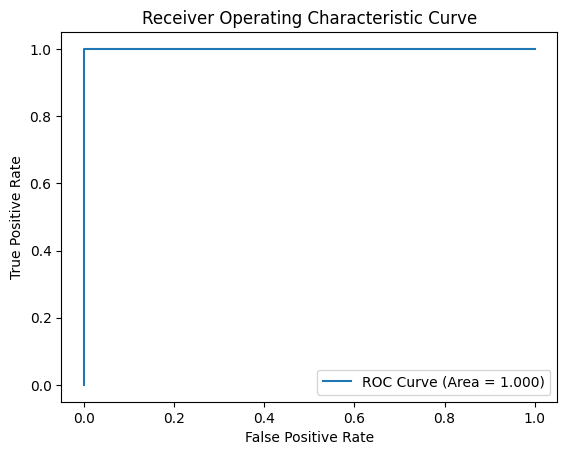

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
sentence_length = 100


def preprocess_and_concatenate(directory, step_size ):
    # 获取指定目录下的所有文件
    files = os.listdir(directory)
    # 过滤出所有的 .npy 文件
    npy_files = [f for f in files if f.endswith('.npy')]

    # 初始化一个空列表来存储数据
    all_data = []

    # 遍历每一个 .npy 文件
    for npy_file in npy_files:

        data = np.load(os.path.join(directory, npy_file))
        num_to_delete = data.shape[0] % step_size
        if num_to_delete != 0:
            data = np.delete(data, np.s_[-num_to_delete:], axis=0)


        len_data = data.shape[0]
        sentences = []
        for i in range(0, len_data - sentence_length + 1, step_size):
            sentence = data[i:i + sentence_length].T
            sentences.append(sentence)

        reshape_data = np.stack(sentences, axis=0)


        all_data.append(reshape_data)

    # 将所有的数据拼接到一起
    all_data = np.concatenate(all_data, axis=0)


    return all_data

# 调用函数

def create_model():

    input_layer = layers.Input(shape=(1024, sentence_length))# 输入层，形状为 (1024, 100)
    x = tf.expand_dims(input_layer, axis=-1)# 增加一个维度，形状变为 (1024, 100, 1)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第一层Conv2D，输出形状为 (1024, 100, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (512, 100, 10)
    x = layers.Conv2D(filters=10, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第二层Conv2D，输出形状为 (512, 100, 10)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (256, 100, 10)
    x = layers.Conv2D(filters=1, kernel_size=(3, 1), padding='same', activation='relu')(x)# 第三层Conv2D，输出形状为 (256, 100, 1)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)# MaxPooling，输出形状为 (128, 100, 1)
    x = tf.squeeze(x, axis=-1)# 去除最后的维度，输出形状为 (128, 100)

    conv1d_layer = x
    # Self-attention layers
    attention_layer1 = MultiHeadAttention(num_heads=10, key_dim=100)(conv1d_layer, conv1d_layer)# 第一层自注意力，输出形状为 (128, 10)
    attention_layer2 = MultiHeadAttention(num_heads=10, key_dim=100)(attention_layer1, attention_layer1)# 第二层自注意力，输出形状为 (128, 10)

    # Flatten layer
    flatten_layer = Flatten()(attention_layer2)

    output_layer = Dense(1, activation='sigmoid')(flatten_layer)# 二分类全连接层，输出形状为 (1,)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output_layer)# 创建模型

    return model

la_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/la_test',20)
jian_data = preprocess_and_concatenate('/content/drive/My Drive/Colab Notebooks/jian_test',20)


print(f"Jian 数据形状: {jian_data.shape}, La 数据形状: {la_data.shape}")
jian_labels = np.ones((jian_data.shape[0], 1))# "jian"类别数据的标签为1
la_labels = np.zeros((la_data.shape[0], 1))# "la"类别数据的标签为0

data = np.concatenate([jian_data, la_data])
labels = np.concatenate([jian_labels, la_labels])# 将两类数据和标签拼接起来，得到完整的数据集


train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.99, random_state=1022)# 将完整的数据集分割为训练集和验证集,这里我们保留20%的数据作为验证集
best_model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/best_model.h5")
start_time = time.time()
val_preds = best_model.predict(val_data)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"经过的时间: {elapsed_time} 秒")
val_preds = np.round(val_preds)
tn, fp, fn, tp = confusion_matrix(val_labels, val_preds).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
recall = recall_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)
roc_auc = roc_auc_score(val_labels, val_preds)

# 打印并保存指
print(f"准确率: {accuracy}")
print(f"召回率: {recall}")
print(f"精确度: {precision}")
print(f"F1得分: {f1}")
print(f"ROC-AUC: {roc_auc}")

# 保存混淆矩阵
print(f"混淆矩阵: \n{confusion_matrix(val_labels, val_preds)}")
fpr, tpr, thresholds = roc_curve(val_labels, val_preds)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (Area = {roc_auc:.3f})')  # .3f formats it to 3 decimal places
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
plt.show()



[ 0.       -0.001831 -0.003662 ... -0.01648  -0.018921 -0.021973]
306/306 [==============================] - 3s 9ms/step
9761
[   0.     225.578  416.571 ... 2203.45  2219.49  2220.34 ]


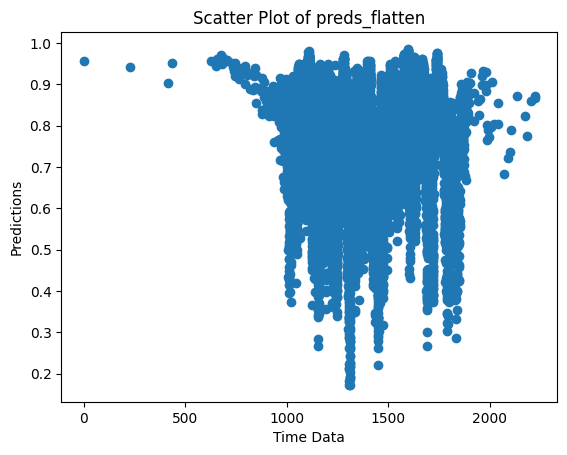

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import plotly.express as px

file_path = '/content/drive/My Drive/Colab Notebooks/jxl4djzwave.npy'
best_model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/best_model.h5")
# 读取.npy文件
data = np.load(file_path)

data = data[:-4, :]
print(data[20,:])
data_cut_list = []

# 循环取出数据
for i in range(0, 9860, 20):
    if i + 100 <= 9860:
        sub_data = data[i:i+100, :].T

        data_cut_list.append(sub_data)
        # 添加到列表

data_cut = np.stack(data_cut_list, axis=0)
preds = best_model.predict(data_cut)
preds_flatten = preds.flatten()  # 如果需要的话，将其展平
print(len(preds_flatten))
file_path = '/content/drive/My Drive/Colab Notebooks/new_jxl4djz.npy'


# 将DataFrame转换为NumPy数组
data =np.load(file_path)

# 提取倒数第二列的数据
time_data = data[:, -2]

time_data = np.insert(time_data, 0, 0)


print(time_data)

if len(time_data) != len(preds_flatten):
    print("Warning: Lengths of time_data and preds_flatten are not equal!")
else:
    plt.scatter(time_data, preds_flatten)

    plt.title("Scatter Plot of preds_flatten")
    plt.xlabel("Time Data")
    plt.ylabel("Predictions")

    plt.show()
    fig = px.scatter(x=time_data, y=preds_flatten, labels={'x':'Time Data', 'y':'Predictions'})

# 添加四条横线

    fig.add_shape(type="line", x0=min(time_data), x1=max(time_data), y0=0.5, y1=0.5, line=dict(color="red", width=1))

# 显示图
    fig.show()

In [41]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import random
file_path = '/content/drive/My Drive/Colab Notebooks/jxl4djz.csv'
df = pd.read_csv(file_path, header=None)

# 将DataFrame转换为NumPy数组
data = df.values

# 提取倒数第二列的数据
time_data = data[:, -2]

time_data = np.insert(time_data, 0, 0)

#9761
print(time_data)


print(len(time_data))

differences = []
for i in range(1, len(time_data)):
    difference = time_data[i] - time_data[i-1]
    differences.append(difference)

# 转换为NumPy数组以使用min函数
differences = np.array(differences)

# 打印小于0.01的元素个数
count = np.sum(differences < 0.02)
print(f"differences 数组中小于0.02的元素个数是：{count}")


indices = []
for i, val in enumerate(differences):
    if val < 0.02:
        indices.append(i)
print(f"小于0.02的元素的索引是：{indices}")


if len(indices) >= 132:
    indices_to_remove = random.sample(indices, 131)
    for idx in indices_to_remove:
        indices.remove(idx)

print(f"删除132个随机元素后的索引数组是：{indices}")

new_data = np.delete(data, np.array(indices), axis=0)

print(f"删除相应行后的data数组的形状是：{new_data.shape}")
print(len(new_data))


time_data = new_data[:, -2]

time_data = np.insert(time_data, 0, 0)

#9761
print(time_data)


print(len(time_data))

differences = []
for i in range(1, len(time_data)):
    difference = time_data[i] - time_data[i-1]
    differences.append(difference)

# 转换为NumPy数组以使用min函数
differences = np.array(differences)

# 打印小于0.01的元素个数
count = np.sum(differences < 0.02)
print(f"differences 数组中小于0.02的元素个数是：{count}")
np.save('new_jxl4djz.npy', new_data)


[   0.     225.578  416.571 ... 2203.45  2219.49  2220.34 ]
17866
differences 数组中小于0.02的元素个数是：8236
小于0.02的元素的索引是：[133, 164, 165, 168, 174, 182, 190, 201, 210, 225, 235, 238, 240, 241, 245, 246, 249, 254, 266, 282, 288, 311, 312, 318, 320, 322, 330, 339, 350, 351, 356, 360, 363, 369, 377, 381, 390, 398, 404, 411, 412, 413, 421, 431, 448, 449, 450, 452, 456, 459, 462, 463, 471, 479, 483, 486, 493, 494, 496, 497, 498, 499, 500, 503, 506, 507, 508, 509, 511, 513, 516, 519, 524, 531, 532, 534, 536, 537, 540, 543, 544, 551, 554, 557, 565, 567, 577, 578, 579, 580, 584, 585, 590, 596, 602, 605, 615, 616, 617, 621, 623, 625, 628, 631, 633, 640, 643, 647, 648, 649, 651, 653, 658, 664, 665, 666, 667, 668, 669, 670, 671, 673, 677, 680, 681, 686, 688, 689, 692, 694, 697, 704, 705, 706, 708, 713, 717, 718, 721, 722, 726, 730, 731, 736, 738, 741, 742, 744, 750, 751, 752, 757, 759, 760, 762, 764, 765, 768, 770, 771, 772, 773, 777, 778, 779, 780, 782, 784, 787, 791, 796, 797, 799, 802, 805, 806, 807, 8

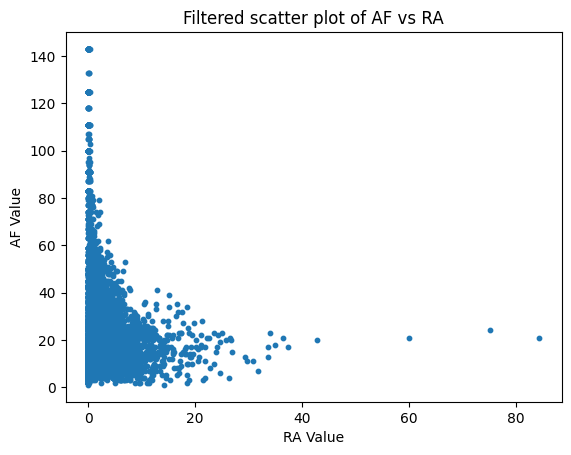

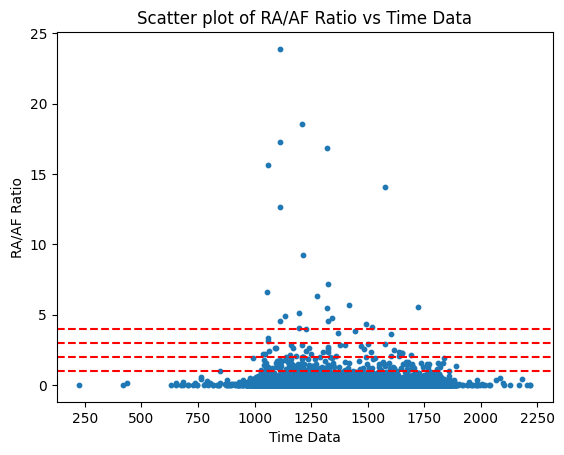

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import random
file_path = '/content/drive/My Drive/Colab Notebooks/new_jxl4djz.npy'
import plotly.express as px
import plotly.graph_objects as go
# 将DataFrame转换为NumPy数组
data =np.load(file_path)
amplitude = data[:, 1]
rise_time = data[:, 8]
af_value = data[:, 10]
time_data = data[:, -2]
# 计算 RA value
ra_value = rise_time / amplitude

filtered_indices = (ra_value < 100) & (af_value < 150)

filtered_ra_value = ra_value[filtered_indices]
filtered_af_value = af_value[filtered_indices]

# 画出散点图，设置散点大小为小值，比如 10 或者更小
plt.scatter(filtered_ra_value, filtered_af_value, s=10)
plt.xlabel('RA Value')
plt.ylabel('AF Value')
plt.title('Filtered scatter plot of AF vs RA')
plt.show()

ra_af_ratio = ra_value / af_value

plt.scatter(time_data, ra_af_ratio, s=10)
plt.xlabel('Time Data')
plt.ylabel('RA/AF Ratio')
plt.title('Scatter plot of RA/AF Ratio vs Time Data')

# 添加四条横线，y坐标分别为1, 2, 3, 和 4
for y in range(1, 5):
    plt.axhline(y=y, color='r', linestyle='--')

plt.show()
fig = go.Figure()

# 添加散点图数据
fig.add_trace(go.Scatter(x=time_data, y=ra_af_ratio, mode='markers',
                         marker=dict(size=8, color='rgba(0, 0, 0, .8)'),
                         name='Data'))

# 添加四条横线
for y in range(1, 5):
    fig.add_shape(type="line", x0=min(time_data), x1=max(time_data), y0=y, y1=y,
                  line=dict(color="rgba(0, 0, 0, .5)", width=1.5, dash="dash"))

# 更新图表的布局和样式
fig.update_layout(
    xaxis_title="Time Data",
    yaxis_title="RA/AF Ratio",
    font=dict(
        family="Helvetica, Arial, monospace",
        size=16,
        color="Black"
    ),
    template='simple_white',
    showlegend=False
)

# 显示图
fig.show()

[ 0.       -0.001831 -0.003662 ... -0.01648  -0.018921 -0.021973]
306/306 [==============================] - 11s 9ms/step
9761
[   0.     225.578  416.571 ... 2203.45  2219.49  2220.34 ]


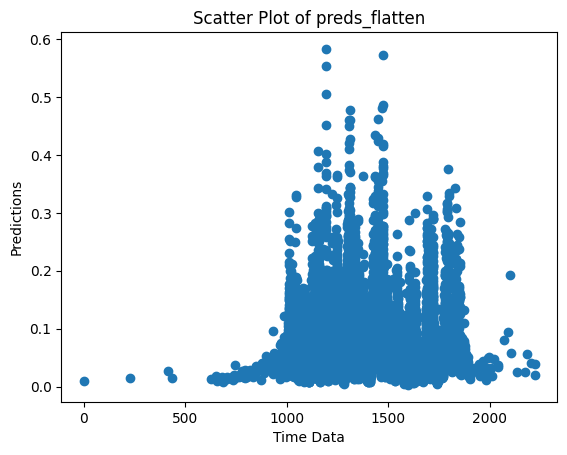

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import plotly.express as px

file_path = '/content/drive/My Drive/Colab Notebooks/jxl4djzwave.npy'
best_model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/best_model_2.h5")
# 读取.npy文件
data = np.load(file_path)

data = data[:-4, :]
print(data[20,:])
data_cut_list = []

# 循环取出数据
for i in range(0, 9860, 1):
    if i + 100 <= 9860:
        sub_data = data[i:i+100, :].T

        data_cut_list.append(sub_data)
        # 添加到列表

data_cut = np.stack(data_cut_list, axis=0)
preds = best_model.predict(data_cut)
preds_flatten = preds.flatten()  # 如果需要的话，将其展平
print(len(preds_flatten))
file_path = '/content/drive/My Drive/Colab Notebooks/new_jxl4djz.npy'


# 将DataFrame转换为NumPy数组
data =np.load(file_path)

# 提取倒数第二列的数据
time_data = data[:, -2]

time_data = np.insert(time_data, 0, 0)


print(time_data)

if len(time_data) != len(preds_flatten):
    print("Warning: Lengths of time_data and preds_flatten are not equal!")
else:
    plt.scatter(time_data, preds_flatten)

    plt.title("Scatter Plot of preds_flatten")
    plt.xlabel("Time Data")
    plt.ylabel("Predictions")

    plt.show()
    fig = px.scatter(x=time_data, y=preds_flatten, labels={'x':'Time Data', 'y':'Predictions'})

# 添加四条横线

    fig.add_shape(type="line", x0=min(time_data), x1=max(time_data), y0=0.5, y1=0.5, line=dict(color="red", width=1))

# 显示图
    fig.show()

In [18]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, MultiHeadAttention
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import random
file_path = '/content/drive/My Drive/Colab Notebooks/new_jxl4djz.npy'
import plotly.express as px
import plotly.graph_objects as go
# 将DataFrame转换为NumPy数组
data =np.load(file_path)
amplitude = data[:, 1]
rise_time = data[:, 8]
af_value = data[:, 10]
time_data = data[:, -2]
# 计算 RA value
ra_value = (rise_time / amplitude)
time_indices_1 =time_data < 950
time_indices_2 =(950 <time_data)& (time_data < 1035)
time_indices_3 =(1035 <time_data)& (time_data < 1350)
time_indices_4 =(1350 <time_data)


fig = px.scatter(x=ra_value[time_indices_1], y=af_value[time_indices_1], labels={'x':'RA', 'y':'AF'})
fig.update_xaxes(range=[0, 5])
fig.update_yaxes(range=[0, 400])
fig.add_shape(type="line", x0=0, x1=2, y0=0, y1=160, line=dict(color="red", width=1))
fig.show()


fig = px.scatter(x=ra_value[time_indices_2], y=af_value[time_indices_2], labels={'x':'RA', 'y':'AF'})
fig.update_xaxes(range=[0, 5])
fig.update_yaxes(range=[0, 400])
fig.add_shape(type="line", x0=0, x1=2, y0=0, y1=160, line=dict(color="red", width=1))
fig.show()


fig = px.scatter(x=ra_value[time_indices_3], y=af_value[time_indices_3], labels={'x':'RA', 'y':'AF'})
fig.update_xaxes(range=[0, 5])
fig.update_yaxes(range=[0, 400])
fig.add_shape(type="line", x0=0, x1=2, y0=0, y1=160, line=dict(color="red", width=1))
fig.show()


fig = px.scatter(x=ra_value[time_indices_4], y=af_value[time_indices_4], labels={'x':'RA', 'y':'AF'})
fig.update_xaxes(range=[0, 5])
fig.update_yaxes(range=[0, 400])
fig.add_shape(type="line", x0=0, x1=2, y0=0, y1=160, line=dict(color="red", width=1))
fig.show()